In [85]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from statsmodels.stats.proportion import proportions_ztest
from tqdm.auto import tqdm
import itertools
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

#### Описание колонок
* experimentVariant – вариант эксперимента
* version – версия приложения
* purchase – факт покупки

In [86]:
df = pd.read_csv('hw_aa.csv', sep=';').drop(columns='Unnamed: 0')
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [77]:
df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


In [78]:
# Для сравнения двух групп между собой
def metric_fpr(df_x, df_y, metric_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    stat_res = {
        'aa': {
            'pvalue': [],
            'mu_x': [],
            'mu_y': []
        },
        'fpr': {
            'fpr_95': 0
        }
    }
    
    for sim in range(n_sim):
        # по умолчанию берем %n_s_perc наблюдений от исходной, но не больше, чем n_s_min
        x = df_x[metric_col].sample(int(min(n_s_min, len(df_x) * n_s_perc)), replace=False).values
        y = df_y[metric_col].sample(int(min(n_s_min, len(df_y) * n_s_perc)), replace=False).values
        
        if estimator == 'prop':
            counts = np.array([sum(x), sum(y)])
            nobs = np.array([len(x), len(y)])
            stat, pvalue = proportions_ztest(counts, nobs, *args, **kwargs)
            
        if estimator == 'ttest':
            stat, pvalue = ss.ttest_ind(x, y, *args, **kwargs)
        
        stat_res['aa']['pvalue'].append(pvalue)
        stat_res['aa']['mu_x'].append(np.mean(x))
        stat_res['aa']['mu_y'].append(np.mean(y))
        
    stat_res['fpr']['fpr_95'] = float(sum(np.array(stat_res['aa']['pvalue']) <= 0.5) / n_sim)
    
    return stat_res

In [79]:
# для вытягивания из датафрейма пар групп
def fpr_report(df, metric_col, variant_col, group_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    
    
    list_fpr = []
    list_group = list(pd.unique(df[group_col])) #подгруппы на которые делим основные группы
    
    for v in range(len(list_group)):
        df_x = df[(df[variant_col] == 0) & (df[group_col] == list_group[v])] #группа 1, версия v
        df_y = df[(df[variant_col] == 1) & (df[group_col] == list_group[v])] #группа 2, версия v
        
        cr_x = sum(df_x[metric]) / len(df_x) #конверсия в покупку для группы 1, версия v
        cr_y = sum(df_y[metric]) / len(df_y) #конверсия в покупку для группы 1, версия v
        
        fpr = {}
        fpr = metric_fpr( # Вызываем функцию, которая будет сравнивать группы 1 и 2 по версии v
            df_x = df_x,
            df_y = df_y,
            metric_col = metric,
            n_sim = n_sim,
            n_s_perc = n_s_perc,
            n_s_min = n_s_min,
            estimator = estimator, *args, **kwargs
        )
        
        is_fpr = (fpr['fpr']['fpr_95']<=0.05) # является ли результат ложно положительным?
        
        list_fpr.append([list_group[v], cr_x, cr_y, fpr['fpr']['fpr_95'], is_fpr]) #добавляем в массив номер варианта, конверсии в двух группах, fpr показатель и 1 или 0 в зависимости от него
    
    report = pd.DataFrame.from_records(list_fpr, columns=['group', 'cr_x', 'cr_y', 'fpr_95', 'is_fpr']) #создаем датафрейм со всеми важными показателями
    return report

In [80]:
n_sim = 1000
n_s_perc = 0.9 #процент значений, которые мы будем брать из главной выборки
n_s_min = 1000
metric = 'purchase'
variant = 'experimentVariant'
group = 'version'

res = fpr_report(
        df=df,
        metric_col='metric', 
        variant_col='experimentVariant',
        group_col='version', 
        n_sim=n_sim, 
        n_s_perc=n_s_perc, 
        n_s_min=n_s_min,
        estimator='ttest'
)
res

,group,cr_x,cr_y,fpr_95,is_fpr
0,v2.8.0,0.000993,0.045606,1.000,False
1,v2.9.0,0.074658,0.071304,0.515,False
2,v3.7.4.0,0.059943,0.063018,0.483,False
3,v3.8.0.0,0.057604,0.062848,0.518,False


1.0


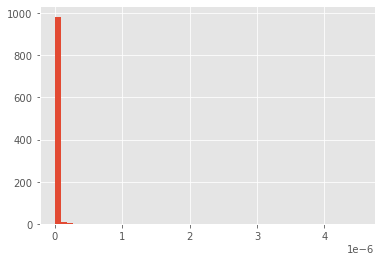

In [81]:
res = metric_fpr(
        df[(df.experimentVariant == 0) & (df['version'] == 'v2.8.0')],
        df[(df.experimentVariant == 1) & (df['version'] == 'v2.8.0')],
        metric_col= metric,  
        n_sim = 1000, 
        n_s_perc = n_s_perc, 
        n_s_min = n_s_min,
        estimator = 'prop'
)

print(res['fpr']['fpr_95'])
plt.hist(res['aa']['pvalue'], bins=50)
plt.style.use('ggplot')
plt.show()

0.51


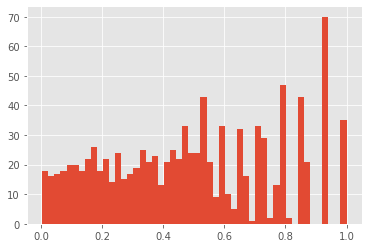

In [82]:
df_filtered = df[(df['version'] != 'v2.8.0')]

res = metric_fpr(
        df_filtered[(df_filtered.experimentVariant == 0)],
        df_filtered[(df_filtered.experimentVariant == 1)],
        metric_col= metric,  
        n_sim = 1000, 
        n_s_perc = n_s_perc, 
        n_s_min = n_s_min,
        estimator = 'prop'
)

print(res['fpr']['fpr_95'])
plt.hist(res['aa']['pvalue'], bins=50)
plt.style.use('ggplot')
plt.show()

In [52]:
control_1 = df[df.experimentVariant == 0]
control_2 = df[df.experimentVariant == 1]

### Базовый алгоритм A/A теста

  0%|          | 0/1000 [00:00<?, ?it/s]

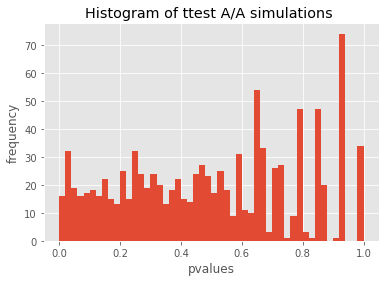

0.058

In [56]:
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = control_1[control_1.version != 'v2.8.0'].purchase.sample(n_s, replace = False).values
    s2 = control_2[control_2.version != 'v2.8.0'].purchase.sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations